In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

In [4]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
x_train = torch.from_numpy(trainset.data.numpy().reshape(-1, 28*28))/255.
y_train = torch.from_numpy(trainset.targets.numpy())
train_data = torch.utils.data.TensorDataset(x_train, y_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
x_test = torch.from_numpy(testset.data.numpy().reshape(-1, 28*28))/255.
y_test = torch.from_numpy(testset.targets.numpy())
test_data = torch.utils.data.TensorDataset(x_test, y_test)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


5


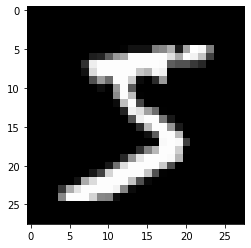

In [5]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


Here, I will first implement a BNN such as in the PAI Task 2. Thus it will be a BNN that is trained via Bayes by Backprop. We will need to change this to train the BNN via SG-MCMC as we said in the Proposal.

First, we need to define the Prior distributions which we will later use in the BNN.

In [10]:
class Prior(nn.Module, abc.ABC):
    """
    This class is a base class for all priors.
    It implements the log_likelihood and sample methods.
    The forward method is not used, but is required by nn.Module.
    This part of the code is inspired by the code from Vincent Fortuin:
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/prior/base.py
    """
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        pass
    
    @abc.abstractmethod
    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Don't use this method, we only implement it because nn.Module requires it
        Vincent Fortuin uses the forward to return the parameter value using self.p
        """
        return self.log_likelihood(x)


In [11]:
class Isotropic_Gaussian(Prior):
    """
    Isotropic Gaussian prior
    """

    def __init__(self, mu: torch.Tensor, sigma: torch.Tensor):
        super(Isotropic_Gaussian, self).__init__()
        #assert all(sigma >= torch.zeros(sigma.size())), "Sigma must be positive"
        self.mu = mu
        self.sigma = sigma

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        return dist.Normal(self.mu, self.sigma).log_prob(x).sum()

    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        return dist.Normal(self.mu, self.sigma).sample()



class Multivariate_Gaussian(Prior):
    """
    Multivariate Gaussian prior
    """
    def __init__(self, mu: torch.Tensor, sigma: torch.Tensor):
        super(Multivariate_Gaussian, self).__init__()
        #assert sigma.shape == mu.shape, "Sigma and mu must have the same shape"
        self.mu = mu
        self.sigma = sigma

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        sigma_resized = torch.reshape(self.sigma, (-1, ))
        mu_resized = torch.reshape(self.mu, (-1, ))
        print(sigma_resized.shape)
        covariance = torch.diag(sigma_resized)

        return dist.MultivariateNormal(mu_resized, covariance).log_prob(x).sum()


    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        sigma_resized = torch.reshape(self.sigma, (-1, ))
        mu_resized = torch.reshape(self.mu, (-1, ))
        covariance = torch.diag(sigma_resized)  

        return dist.MultivariateNormal(mu_resized, covariance).sample()



Next, we need to define a basic module for one single Bayesian Layer. This module will then be used as building block for the full BNN. 


In [15]:
class Linear_Layer(nn.Linear):
    """
    Bayesian Linear Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """ 
    def __init__(self, in_features, out_features, bias = True):
        super().__init__(in_features, out_features, bias)
        self.in_features = in_features
        self.out_features = out_features
        self.with_bias = bias

        # create a prior for the weights and biases using the Isotropic Gaussian prior
        self.weight_prior = Isotropic_Gaussian(
            mu = torch.zeros(out_features, in_features),
            sigma = torch.ones(out_features, in_features)
        )

        if self.with_bias:
            self.bias_prior = Isotropic_Gaussian(
                mu = torch.zeros(out_features),
                sigma = torch.ones(out_features)
            )
        
        # create a variational posterior for the weights and biases as Instance of  Multivariate Gaussian
        self.weight_posterior = Isotropic_Gaussian(
            mu = torch.nn.Parameter(torch.zeros(out_features, in_features)),
            sigma = torch.nn.Parameter(torch.ones(out_features, in_features))
        )
        
        if self.with_bias:
            self.bias_posterior = Isotropic_Gaussian(
                mu = torch.nn.Parameter(torch.zeros(out_features)),
                sigma = torch.nn.Parameter(torch.ones(out_features))
            )
        else:
            self.register_parameter('bias', None)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Same procedure as explained in the paper of Blundell et al. (2015):
        use reparameterization trick to sample weights and biases from the variational posterior
        """
        # usample random noise from the standard normal distribution
        epsilon = torch.randn_like(self.weight_posterior.mu)

        # sample weights and biases from the variational posterior
        weight = self.weight_posterior.mu + torch.multiply(epsilon, self.weight_posterior.sigma)

        # compute the log prior of the weights and biases
        log_prior = self.weight_prior.log_likelihood(weight)

        # compute the log variational posterior of the weights and biases
        log_posterior = self.weight_posterior.log_likelihood(weight)

        # adjust for the bias
        if self.with_bias:
            epsilon = torch.randn_like(self.bias_posterior.mu)
            bias = self.bias_posterior.mu + torch.multiply(epsilon, self.bias_posterior.sigma)
            log_prior += self.bias_prior.log_likelihood(bias)
            log_posterior += self.bias_posterior.log_likelihood(bias)
        else:
            bias = None


        kl_divergence = log_posterior - log_prior
        
        # compute the output of the layer
        output = F.linear(x, weight, bias)
        return output, kl_divergence


        




In [18]:

class Bayesian_Neural_Network(nn.Module):
    """
    Bayesian Neural Network that will be trained using the BNN implementation
    """ 
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims

        # create the layers of the network
        self.layers = nn.ModuleList()

        # create the input layer
        self.layers.append(Linear_Layer(self.input_dim, self.hidden_dims[0]))
        #self.layers.append(nn.ReLU(inplace=True))

        # create the hidden layers
        for i in range(len(self.hidden_dims) - 1):
            self.layers.append(Linear_Layer(self.hidden_dims[i], self.hidden_dims[i + 1]))
            #self.layers.append(nn.ReLU(inplace=True))

        # create the output layer
        self.layers.append(Linear_Layer(self.hidden_dims[-1], self.output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network
        """
        kl_divergence = 0
        for ind, layer in enumerate(self.layers):
            x, kl = layer(x)
            kl_divergence += kl
            if ind < len(self.layers) - 1:
                x = F.relu(x)

        return x, kl_divergence

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        Predict the output of the network and return the output
        """
        with torch.no_grad():
            output, _ = self.forward(x)
            return output





In [19]:
# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100])
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the model
epochs = 10

for epoch in tqdm.tqdm(range(epochs)):
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # forward pass
        output, kl_divergence = model(x)

        # compute the loss
        loss = F.nll_loss(F.softmax(output, dim = 1), y) + kl_divergence

        # backward pass
        loss.backward()
        optimizer.step()
        

        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}")

        

  0%|          | 0/10 [00:00<?, ?it/s]

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      in_features=784, out_features=100, bias=True
      (weight_prior): Isotropic_Gaussian()
      (bias_prior): Isotropic_Gaussian()
      (weight_posterior): Isotropic_Gaussian()
      (bias_posterior): Isotropic_Gaussian()
    )
    (1): Linear_Layer(
      in_features=100, out_features=10, bias=True
      (weight_prior): Isotropic_Gaussian()
      (bias_prior): Isotropic_Gaussian()
      (weight_posterior): Isotropic_Gaussian()
      (bias_posterior): Isotropic_Gaussian()
    )
  )
)
Epoch: 0 | Batch: 0 | Loss: -0.09515979886054993
Epoch: 0 | Batch: 100 | Loss: 16.86176300048828
Epoch: 0 | Batch: 200 | Loss: 11.615659713745117
Epoch: 0 | Batch: 300 | Loss: 20.14438819885254
Epoch: 0 | Batch: 400 | Loss: 35.73916244506836
Epoch: 0 | Batch: 500 | Loss: 27.11829376220703
Epoch: 0 | Batch: 600 | Loss: 49.077762603759766
Epoch: 0 | Batch: 700 | Loss: 43.770992279052734
Epoch: 0 | Batch: 800 | Loss: 43.5404510498046

 10%|█         | 1/10 [00:18<02:43, 18.19s/it]

Epoch: 1 | Batch: 0 | Loss: 48.598411560058594
Epoch: 1 | Batch: 100 | Loss: 32.84897232055664
Epoch: 1 | Batch: 200 | Loss: 47.80905532836914
Epoch: 1 | Batch: 300 | Loss: 52.07752227783203
Epoch: 1 | Batch: 400 | Loss: 58.828125
Epoch: 1 | Batch: 500 | Loss: 37.8927001953125
Epoch: 1 | Batch: 600 | Loss: 47.0234375
Epoch: 1 | Batch: 700 | Loss: 60.4962158203125
Epoch: 1 | Batch: 800 | Loss: 37.74379348754883
Epoch: 1 | Batch: 900 | Loss: 45.35428237915039


 20%|██        | 2/10 [00:34<02:21, 17.69s/it]

Epoch: 2 | Batch: 0 | Loss: 48.692848205566406
Epoch: 2 | Batch: 100 | Loss: 43.869686126708984
Epoch: 2 | Batch: 200 | Loss: 41.08445358276367
Epoch: 2 | Batch: 300 | Loss: 60.556640625
Epoch: 2 | Batch: 400 | Loss: 50.426170349121094
Epoch: 2 | Batch: 500 | Loss: 42.48792266845703
Epoch: 2 | Batch: 600 | Loss: 36.6080322265625
Epoch: 2 | Batch: 700 | Loss: 33.66780471801758
Epoch: 2 | Batch: 800 | Loss: 51.15086364746094
Epoch: 2 | Batch: 900 | Loss: 48.3382568359375


 30%|███       | 3/10 [00:55<02:10, 18.60s/it]

Epoch: 3 | Batch: 0 | Loss: 48.87843322753906
Epoch: 3 | Batch: 100 | Loss: 59.371829986572266
Epoch: 3 | Batch: 200 | Loss: 46.99433898925781
Epoch: 3 | Batch: 300 | Loss: 28.010833740234375
Epoch: 3 | Batch: 400 | Loss: 42.119693756103516
Epoch: 3 | Batch: 500 | Loss: 61.715606689453125
Epoch: 3 | Batch: 600 | Loss: 39.11267852783203
Epoch: 3 | Batch: 700 | Loss: 59.35221481323242
Epoch: 3 | Batch: 800 | Loss: 47.64887237548828
Epoch: 3 | Batch: 900 | Loss: 36.8270263671875


 40%|████      | 4/10 [01:15<01:54, 19.15s/it]

Epoch: 4 | Batch: 0 | Loss: 51.71307373046875
Epoch: 4 | Batch: 100 | Loss: 38.1565055847168
Epoch: 4 | Batch: 200 | Loss: 41.11244201660156
Epoch: 4 | Batch: 300 | Loss: 53.61478805541992
Epoch: 4 | Batch: 400 | Loss: 39.54041290283203
Epoch: 4 | Batch: 500 | Loss: 46.080528259277344
Epoch: 4 | Batch: 600 | Loss: 57.41802215576172
Epoch: 4 | Batch: 700 | Loss: 43.958316802978516
Epoch: 4 | Batch: 800 | Loss: 38.133548736572266
Epoch: 4 | Batch: 900 | Loss: 53.07054901123047


 50%|█████     | 5/10 [01:45<01:51, 22.37s/it]

Epoch: 5 | Batch: 0 | Loss: 54.239776611328125
Epoch: 5 | Batch: 100 | Loss: 56.714599609375
Epoch: 5 | Batch: 200 | Loss: 44.83207702636719
Epoch: 5 | Batch: 300 | Loss: 61.292823791503906
Epoch: 5 | Batch: 400 | Loss: 36.64524459838867
Epoch: 5 | Batch: 500 | Loss: 28.873455047607422
Epoch: 5 | Batch: 600 | Loss: 58.31439208984375
Epoch: 5 | Batch: 700 | Loss: 45.44308853149414
Epoch: 5 | Batch: 800 | Loss: 47.891597747802734
Epoch: 5 | Batch: 900 | Loss: 45.1481819152832


 60%|██████    | 6/10 [02:08<01:29, 22.34s/it]

Epoch: 6 | Batch: 0 | Loss: 38.04106140136719
Epoch: 6 | Batch: 100 | Loss: 56.051666259765625
Epoch: 6 | Batch: 200 | Loss: 34.644676208496094
Epoch: 6 | Batch: 300 | Loss: 51.28498840332031
Epoch: 6 | Batch: 400 | Loss: 37.65415573120117
Epoch: 6 | Batch: 500 | Loss: 52.9639892578125
Epoch: 6 | Batch: 600 | Loss: 35.021385192871094
Epoch: 6 | Batch: 700 | Loss: 40.820106506347656
Epoch: 6 | Batch: 800 | Loss: 47.53953170776367
Epoch: 6 | Batch: 900 | Loss: 48.847660064697266


 70%|███████   | 7/10 [02:29<01:06, 22.08s/it]

Epoch: 7 | Batch: 0 | Loss: 51.4085693359375
Epoch: 7 | Batch: 100 | Loss: 50.15510559082031
Epoch: 7 | Batch: 200 | Loss: 41.41136932373047
Epoch: 7 | Batch: 300 | Loss: 48.4462890625
Epoch: 7 | Batch: 400 | Loss: 67.11390686035156
Epoch: 7 | Batch: 500 | Loss: 48.664180755615234
Epoch: 7 | Batch: 600 | Loss: 40.53447723388672
Epoch: 7 | Batch: 700 | Loss: 58.56099319458008
Epoch: 7 | Batch: 800 | Loss: 51.439453125
Epoch: 7 | Batch: 900 | Loss: 36.07307052612305


 80%|████████  | 8/10 [02:48<00:42, 21.08s/it]

Epoch: 8 | Batch: 0 | Loss: 51.29830551147461
Epoch: 8 | Batch: 100 | Loss: 36.28865432739258
Epoch: 8 | Batch: 200 | Loss: 34.14769744873047
Epoch: 8 | Batch: 300 | Loss: 56.631195068359375
Epoch: 8 | Batch: 400 | Loss: 37.91389465332031
Epoch: 8 | Batch: 500 | Loss: 50.876380920410156
Epoch: 8 | Batch: 600 | Loss: 36.20116424560547
Epoch: 8 | Batch: 700 | Loss: 50.550228118896484
Epoch: 8 | Batch: 800 | Loss: 44.772300720214844
Epoch: 8 | Batch: 900 | Loss: 55.46240997314453


 90%|█████████ | 9/10 [03:12<00:22, 22.06s/it]

Epoch: 9 | Batch: 0 | Loss: 59.09617614746094
Epoch: 9 | Batch: 100 | Loss: 48.49892044067383
Epoch: 9 | Batch: 200 | Loss: 43.729331970214844
Epoch: 9 | Batch: 300 | Loss: 58.735713958740234
Epoch: 9 | Batch: 400 | Loss: 40.561767578125
Epoch: 9 | Batch: 500 | Loss: 45.02233123779297
Epoch: 9 | Batch: 600 | Loss: 47.851173400878906
Epoch: 9 | Batch: 700 | Loss: 72.2313003540039
Epoch: 9 | Batch: 800 | Loss: 43.877197265625
Epoch: 9 | Batch: 900 | Loss: 60.916175842285156


 90%|█████████ | 9/10 [03:34<00:23, 23.86s/it]


KeyboardInterrupt: 

6146560000

In [ ]:


# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_size=28*28, hidden_size=100, output_size=10)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs = 15
progress_bar = tqdm(epochs)

for epoch in progress_bar:
    for x, y in train_loader:
        # reshape the input
        x = x.view(-1, 28*28)

        # compute the output of the network
        y_hat, log_prior, log_posterior = model(x)

        # compute the loss
        loss = loss_fn(y_hat, y) - log_prior + log_posterior

        # compute the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # reset the gradients
        optimizer.zero_grad()

    # compute the accuracy
    accuracy = (model.predict_class(x) == y).float().mean()

    # update the progress bar
    progress_bar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}")




In [ ]:
class Conv_Layer(nn.Conv2d):
    """
    Bayesian Convolutional Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = True):
        super(Conv_Layer, self).__init__()
        pass